# Свёрточные нейросети и POS-теггинг

POS-теггинг - определение частей речи (снятие частеречной неоднозначности)

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

Cloning into 'stepik-dl-nlp'...
remote: Enumerating objects: 289, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 289 (delta 10), reused 14 (delta 6), pack-reused 266
Receiving objects: 100% (289/289), 42.27 MiB | 24.49 MiB/s, done.
Resolving deltas: 100% (139/139), done.
     |████████████████████████████████| 61kB 5.9MB/s 
     |████████████████████████████████| 1.7MB 24.6MB/s 
     |████████████████████████████████| 24.2MB 1.8MB/s 
     |████████████████████████████████| 307kB 48.9MB/s 
     |████████████████████████████████| 8.2MB 47.1MB/s 
  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=00c1c8e5a3ba470e6c60163ffedc1fe2a089b7b583d483ecb19311e420529848
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
  Created wheel for ufal.udpipe: filename=ufal.udpipe-1.2.0.3-cp37-cp37m-linux_x86_64.whl size=5626600 sha256=925db603ed78030ce4b4b

In [ ]:
!pip install pyconll
# !pip install spacy_udpipe

In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report

import numpy as np

import pyconll

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, \
    character_tokenize, pos_corpus_to_tensor, POSTagger
from dlnlputils.pipeline import train_eval_loop, predict_with_model, init_random_seed

init_random_seed()

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
# !wget -O ./stepik-dl-nlp/datasets/ru_syntagrus-ud-train.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-train.conllu
# !wget -O ./stepik-dl-nlp/datasets/ru_syntagrus-ud-dev.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-dev.conllu

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
# full_train = pyconll.load_from_file('./stepik-dl-nlp/datasets/ru_syntagrus-ud-train.conllu')
# full_test = pyconll.load_from_file('./stepik-dl-nlp/datasets/ru_syntagrus-ud-dev.conllu')

In [ ]:
# full = pyconll.load_from_file('/content/data_sah.conllu')

In [ ]:
full = pyconll.load_from_file('/content/postag_sakha.conllu')

In [ ]:
len(full)

2380

In [ ]:
full_train = full[:1700]
full_test = full[1700:]

In [ ]:
print(len(full_train), len(full_test))

1700 680


In [ ]:
for sent in full_train[:3]:
    for token in sent:
        print(token.form, token.upos)
    print()

Сонун NOUN
сэргэх ADV
буолан VERB
иһэр VERB
. PUNCT

Туох NOUN
ханнык ADJ
иннинэ PR
саамай ADJ
сөбүлээн ADV
ааҕар VERB
« SYM
Кыым NOUN
» SYM
хаһыаппыт NOUN
85 NUM
сааһын NOUN
туолар VERB
үбүлүөйүнэн NOUN
истиҥник ADV
эҕэрдэлиибин VERB
. PUNCT

Хаһыат NOUN
үлэһиттэригэр NOUN
туйгун ADJ
доруобуйаны NOUN
, PUNCT
дьолу NOUN
- PUNCT
соргуну NOUN
, PUNCT
айымньылаах ADJ
үлэни NOUN
баҕарабын VERB
! PUNCT



In [ ]:
MAX_SENT_LEN = max(len(sent) for sent in full_train)
MAX_ORIG_TOKEN_LEN = max(len(token.form) for sent in full_train for token in sent)
print('Наибольшая длина предложения', MAX_SENT_LEN)
print('Наибольшая длина токена', MAX_ORIG_TOKEN_LEN)

Наибольшая длина предложения 75
Наибольшая длина токена 25


In [ ]:
all_train_texts = [' '.join(token.form for token in sent) for sent in full_train]
print('\n'.join(all_train_texts[:10]))

Сонун сэргэх буолан иһэр .
Туох ханнык иннинэ саамай сөбүлээн ааҕар « Кыым » хаһыаппыт 85 сааһын туолар үбүлүөйүнэн истиҥник эҕэрдэлиибин .
Хаһыат үлэһиттэригэр туйгун доруобуйаны , дьолу - соргуну , айымньылаах үлэни баҕарабын !
Мин « Кыым » хаһыаты оскуола боруогун атыллаан буукубаны билиэхпиттэн олус сөбүлээн ааҕабын .
Биһиги кыра эрдэхпитинэ « Кыымы » тиһигин быспакка ааҕарбыт .
Почта кэллэ да дьиэлээхтэр тула олорон « Кыымы » сиһилии аахтараллара , тыыммакка да олорон истэллэрэ .
Онон олус күүтүүлээх хаһыат этэ .
Кэлин былаас уларыйыытыгар « Кыым » хаһыаты сабар уураах тахсыбыта .
Саха тыллаах былыргыттан сөбүлээн ааҕар хаһыаттара сабылларын хомойо истибиттэрэ .
Онтон биир дойдулаахпыт Ф . П . Егорова туруулаһан хаһыаты иккистээн тилиннэрбитин олус долгуйа , үөрэ , махтана истибиппит .


In [ ]:
train_char_tokenized = tokenize_corpus(all_train_texts, tokenizer=character_tokenize)
char_vocab, word_doc_freq = build_vocabulary(train_char_tokenized, max_doc_freq=1.0, min_count=5, pad_word='<PAD>')
print("Количество уникальных символов", len(char_vocab))
print(list(char_vocab.items())[:10])

Количество уникальных символов 94
[('<PAD>', 0), (' ', 1), ('а', 2), ('.', 3), ('р', 4), ('т', 5), ('н', 6), ('л', 7), ('э', 8), ('и', 9)]


In [ ]:
UNIQUE_TAGS = ['<NOTAG>'] + sorted({token.upos for sent in full_train for token in sent if token.upos})
label2id = {label: i for i, label in enumerate(UNIQUE_TAGS)}
label2id

{'<NOTAG>': 0,
 'ADJ': 1,
 'ADV': 2,
 'AUX': 3,
 'CONJ': 4,
 'INTJ': 5,
 'NOUN': 6,
 'NUM': 7,
 'PART': 8,
 'PR': 9,
 'PRON': 10,
 'PUNCT': 11,
 'SYM': 12,
 'VERB': 13,
 'X': 14}

In [ ]:
train_inputs, train_labels = pos_corpus_to_tensor(full_train, char_vocab, label2id, MAX_SENT_LEN, MAX_ORIG_TOKEN_LEN)
train_dataset = TensorDataset(train_inputs, train_labels)

test_inputs, test_labels = pos_corpus_to_tensor(full_test, char_vocab, label2id, MAX_SENT_LEN, MAX_ORIG_TOKEN_LEN)
test_dataset = TensorDataset(test_inputs, test_labels)

In [ ]:
train_inputs[1][:5]

tensor([[ 0, 44, 13, 14, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 16,  2,  6,  6, 12, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  9,  6,  6,  9,  6,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 10,  2,  2, 20,  2, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 10, 25, 11, 22,  7,  8,  8,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [ ]:
train_labels[0]

tensor([ 6,  2, 13, 13, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0])

## Вспомогательная свёрточная архитектура

In [ ]:
class StackedConv1d(nn.Module):
    def __init__(self, features_num, layers_n=1, kernel_size=3, conv_layer=nn.Conv1d, dropout=0.0):
        super().__init__()
        layers = []
        for _ in range(layers_n):
            layers.append(nn.Sequential(
                conv_layer(features_num, features_num, kernel_size, padding=kernel_size//2),
                nn.Dropout(dropout),
                nn.LeakyReLU()))
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        """x - BatchSize x FeaturesNum x SequenceLen"""
        for layer in self.layers:
            x = x + layer(x)
        return x

## Предсказание частей речи на уровне отдельных токенов

In [ ]:
class SingleTokenPOSTagger(nn.Module):
    def __init__(self, vocab_size, labels_num, embedding_size=32, **kwargs):
        super().__init__()
        self.char_embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.backbone = StackedConv1d(embedding_size, **kwargs)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.out = nn.Linear(embedding_size, labels_num)
        self.labels_num = labels_num
    
    def forward(self, tokens):
        """tokens - BatchSize x MaxSentenceLen x MaxTokenLen"""
        batch_size, max_sent_len, max_token_len = tokens.shape
        tokens_flat = tokens.view(batch_size * max_sent_len, max_token_len)
        
        char_embeddings = self.char_embeddings(tokens_flat)  # BatchSize*MaxSentenceLen x MaxTokenLen x EmbSize
        char_embeddings = char_embeddings.permute(0, 2, 1)  # BatchSize*MaxSentenceLen x EmbSize x MaxTokenLen
        
        features = self.backbone(char_embeddings)
        
        global_features = self.global_pooling(features).squeeze(-1)  # BatchSize*MaxSentenceLen x EmbSize
        
        logits_flat = self.out(global_features)  # BatchSize*MaxSentenceLen x LabelsNum
        logits = logits_flat.view(batch_size, max_sent_len, self.labels_num)  # BatchSize x MaxSentenceLen x LabelsNum
        logits = logits.permute(0, 2, 1)  # BatchSize x LabelsNum x MaxSentenceLen
        return logits

In [ ]:
single_token_model = SingleTokenPOSTagger(len(char_vocab), len(label2id), 
          embedding_size=64, layers_n=3, kernel_size=3, dropout=0.3)
print('Количество параметров', sum(np.product(t.shape) for t in single_token_model.parameters()))

Количество параметров 44047


In [ ]:
(best_val_loss,
 best_single_token_model) = train_eval_loop(single_token_model,
                                            train_dataset,
                                            test_dataset,
                                            F.cross_entropy,
                                            lr=5e-3,
                                            epoch_n=30,
                                            batch_size=64,
                                            device='cuda',
                                            early_stopping_patience=5,
                                            max_batches_per_epoch_train=500,
                                            max_batches_per_epoch_val=100,
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=2,
                                                                                                                       factor=0.5,
                                                                                                                       verbose=True))

Эпоха 0
Эпоха: 27 итераций, 2.10 сек
Среднее значение функции потерь на обучении 0.12840909207308734
Среднее значение функции потерь на валидации 0.15480779653245752
Новая лучшая модель!

Эпоха 1
Эпоха: 27 итераций, 1.94 сек
Среднее значение функции потерь на обучении 0.11056742210079122
Среднее значение функции потерь на валидации 0.13351449912244623
Новая лучшая модель!

Эпоха 2
Эпоха: 27 итераций, 1.94 сек
Среднее значение функции потерь на обучении 0.10862910002470016
Среднее значение функции потерь на валидации 0.13340924206105145
Новая лучшая модель!

Эпоха 3
Эпоха: 27 итераций, 1.94 сек
Среднее значение функции потерь на обучении 0.10795001630429868
Среднее значение функции потерь на валидации 0.13149611922827634
Новая лучшая модель!

Эпоха 4
Эпоха: 27 итераций, 1.95 сек
Среднее значение функции потерь на обучении 0.10720293527400052
Среднее значение функции потерь на валидации 0.1312906416979703
Новая лучшая модель!

Эпоха 5
Эпоха: 27 итераций, 1.94 сек
Среднее значение функции

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(best_single_token_model.state_dict(), './stepik-dl-nlp/models/single_token_pos.pth')

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
single_token_model.load_state_dict(torch.load('/content/stepik-dl-nlp/models/single_token_pos.pth', map_location={'cuda:0': 'cpu'}))

<All keys matched successfully>

In [ ]:
weight=[0,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

In [ ]:
train_pred = predict_with_model(single_token_model, train_dataset)
train_loss = F.cross_entropy(torch.tensor(train_pred),
                             torch.tensor(train_labels))
print('Среднее значение функции потерь на обучении', float(train_loss))
print(classification_report(train_labels.view(-1), train_pred.argmax(1).reshape(-1), labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14], target_names=UNIQUE_TAGS[1:]))
print()

test_pred = predict_with_model(single_token_model, test_dataset)
test_loss = F.cross_entropy(torch.tensor(test_pred),
                            torch.tensor(test_labels))
print('Среднее значение функции потерь на валидации', float(test_loss))
print(classification_report(test_labels.view(-1), test_pred.argmax(1).reshape(-1), labels=[1,2,3,4,5,6,7,8,9,10,11,12,13], target_names=UNIQUE_TAGS[1:14]))

54it [00:01, 52.23it/s]
  0%|          | 0/21.25 [00:00<?, ?it/s]

Среднее значение функции потерь на обучении 0.08269870281219482
              precision    recall  f1-score   support

         ADJ       0.74      0.71      0.73      1558
         ADV       0.68      0.53      0.59      1015
         AUX       0.62      0.50      0.56       187
        CONJ       0.78      0.67      0.72       546
        INTJ       0.86      0.50      0.63        24
        NOUN       0.91      0.92      0.91      7990
         NUM       0.89      0.91      0.90       816
        PART       0.72      0.44      0.54       746
          PR       0.64      0.57      0.60       470
        PRON       0.85      0.94      0.89      1047
       PUNCT       0.99      0.98      0.99      4423
         SYM       0.93      0.96      0.95       744
        VERB       0.82      0.93      0.87      4482
           X       0.00      0.00      0.00         3

   micro avg       0.87      0.87      0.87     24051
   macro avg       0.75      0.68      0.71     24051
weighted avg    

22it [00:00, 53.54it/s]                           


Среднее значение функции потерь на валидации 0.1235571876168251
              precision    recall  f1-score   support

         ADJ       0.62      0.63      0.62       605
         ADV       0.51      0.42      0.46       346
         AUX       0.24      0.22      0.23        63
        CONJ       0.61      0.65      0.63       170
        INTJ       0.22      0.40      0.29         5
        NOUN       0.85      0.86      0.86      3082
         NUM       0.90      0.87      0.88       281
        PART       0.66      0.54      0.59       276
          PR       0.68      0.52      0.59       233
        PRON       0.95      0.87      0.91       471
       PUNCT       0.98      0.99      0.98      1786
         SYM       0.97      0.71      0.82       363
        VERB       0.81      0.87      0.83      1812

   micro avg       0.83      0.83      0.83      9493
   macro avg       0.69      0.66      0.67      9493
weighted avg       0.83      0.83      0.83      9493



## Предсказание частей речи на уровне предложений (с учётом контекста)

In [ ]:
class SentenceLevelPOSTagger(nn.Module):
    def __init__(self, vocab_size, labels_num, embedding_size=32, 
                 single_backbone_kwargs={}, context_backbone_kwargs={}):
        super().__init__()
        self.embedding_size = embedding_size
        self.char_embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.single_token_backbone = StackedConv1d(embedding_size, **single_backbone_kwargs)
        self.context_backbone = StackedConv1d(embedding_size, **context_backbone_kwargs)
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.out = nn.Conv1d(embedding_size, labels_num, 1)
        self.labels_num = labels_num
    
    def forward(self, tokens):
        """tokens - BatchSize x MaxSentenceLen x MaxTokenLen"""
        batch_size, max_sent_len, max_token_len = tokens.shape
        tokens_flat = tokens.view(batch_size * max_sent_len, max_token_len)
        
        char_embeddings = self.char_embeddings(tokens_flat)  # BatchSize*MaxSentenceLen x MaxTokenLen x EmbSize
        char_embeddings = char_embeddings.permute(0, 2, 1)  # BatchSize*MaxSentenceLen x EmbSize x MaxTokenLen
        char_features = self.single_token_backbone(char_embeddings)
        
        token_features_flat = self.global_pooling(char_features).squeeze(-1)  # BatchSize*MaxSentenceLen x EmbSize

        token_features = token_features_flat.view(batch_size, max_sent_len, self.embedding_size)  # BatchSize x MaxSentenceLen x EmbSize
        token_features = token_features.permute(0, 2, 1)  # BatchSize x EmbSize x MaxSentenceLen
        context_features = self.context_backbone(token_features)  # BatchSize x EmbSize x MaxSentenceLen

        logits = self.out(context_features)  # BatchSize x LabelsNum x MaxSentenceLen
        return logits

In [ ]:
sentence_level_model = SentenceLevelPOSTagger(len(char_vocab), len(label2id), embedding_size=64,
                                              single_backbone_kwargs=dict(layers_n=3, kernel_size=3, dropout=0.3),
                                              context_backbone_kwargs=dict(layers_n=3, kernel_size=3, dropout=0.3))
print('Количество параметров', sum(np.product(t.shape) for t in sentence_level_model.parameters()))

Количество параметров 81103


In [ ]:
(best_val_loss,
 best_sentence_level_model) = train_eval_loop(sentence_level_model,
                                              train_dataset,
                                              test_dataset,
                                              F.cross_entropy,
                                              lr=5e-3,
                                              epoch_n=30,
                                              batch_size=64,
                                              device='cuda',
                                              early_stopping_patience=5,
                                              max_batches_per_epoch_train=500,
                                              max_batches_per_epoch_val=100,
                                              lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=2,
                                                                                                                         factor=0.5,
                                                                                                                         verbose=True))

Эпоха 0
Эпоха: 27 итераций, 1.95 сек
Среднее значение функции потерь на обучении 0.6536182021653211
Среднее значение функции потерь на валидации 0.23504994945092636
Новая лучшая модель!

Эпоха 1
Эпоха: 27 итераций, 1.61 сек
Среднее значение функции потерь на обучении 0.20972423255443573
Среднее значение функции потерь на валидации 0.18883840333331714
Новая лучшая модель!

Эпоха 2
Эпоха: 27 итераций, 1.61 сек
Среднее значение функции потерь на обучении 0.17785399545122077
Среднее значение функции потерь на валидации 0.16575947200710123
Новая лучшая модель!

Эпоха 3
Эпоха: 27 итераций, 1.61 сек
Среднее значение функции потерь на обучении 0.16112392864845418
Среднее значение функции потерь на валидации 0.1533808789469979
Новая лучшая модель!

Эпоха 4
Эпоха: 27 итераций, 1.61 сек
Среднее значение функции потерь на обучении 0.1486759740445349
Среднее значение функции потерь на валидации 0.1446139792149717
Новая лучшая модель!

Эпоха 5
Эпоха: 27 итераций, 1.61 сек
Среднее значение функции по

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(best_sentence_level_model.state_dict(), './stepik-dl-nlp/models/sentence_level_pos.pth')

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
sentence_level_model.load_state_dict(torch.load('./stepik-dl-nlp/models/sentence_level_pos.pth', map_location={'cuda:0': 'cpu'}))

<All keys matched successfully>

In [ ]:
UNIQUE_TAGS1 = ['ADJ','ADV','AUX','CONJ','INTJ','NOUN','NUM','PART','PR','PRON','VERB']

In [ ]:
from sklearn.metrics import confusion_matrix
train_pred = predict_with_model(sentence_level_model, train_dataset)
train_loss = F.cross_entropy(torch.tensor(train_pred),
                             torch.tensor(train_labels))
print('Среднее значение функции потерь на обучении', float(train_loss))
print(classification_report(train_labels.view(-1), train_pred.argmax(1).reshape(-1),  labels=[1,2,3,4,5,6,7,8,9,10,13], target_names=UNIQUE_TAGS1))
print()

test_pred = predict_with_model(sentence_level_model, test_dataset)
test_loss = F.cross_entropy(torch.tensor(test_pred),
                            torch.tensor(test_labels))
print('Среднее значение функции потерь на валидации', float(test_loss))
print(classification_report(test_labels.view(-1), test_pred.argmax(1).reshape(-1),  labels=[1,2,3,4,5,6,7,8,9,10,13], target_names=UNIQUE_TAGS1))
print(confusion_matrix(test_labels.view(-1), test_pred.argmax(1).reshape(-1)))


54it [00:00, 140.50it/s]                            
  0%|          | 0/21.25 [00:00<?, ?it/s]

Среднее значение функции потерь на обучении 0.0740540474653244
              precision    recall  f1-score   support

         ADJ       0.82      0.65      0.72      1558
         ADV       0.72      0.45      0.56      1015
         AUX       0.69      0.55      0.61       187
        CONJ       0.73      0.71      0.72       546
        INTJ       0.86      0.50      0.63        24
        NOUN       0.90      0.93      0.91      7990
         NUM       0.89      0.91      0.90       816
        PART       0.70      0.53      0.60       746
          PR       0.60      0.69      0.64       470
        PRON       0.83      0.95      0.89      1047
        VERB       0.85      0.93      0.89      4482

   micro avg       0.85      0.85      0.85     18881
   macro avg       0.78      0.71      0.73     18881
weighted avg       0.84      0.85      0.84     18881




22it [00:00, 195.35it/s]                           


Среднее значение функции потерь на валидации 0.10650773346424103
              precision    recall  f1-score   support

         ADJ       0.66      0.53      0.59       605
         ADV       0.59      0.37      0.45       346
         AUX       0.28      0.27      0.28        63
        CONJ       0.53      0.68      0.60       170
        INTJ       0.25      0.40      0.31         5
        NOUN       0.84      0.88      0.86      3082
         NUM       0.91      0.84      0.87       281
        PART       0.57      0.55      0.56       276
          PR       0.62      0.60      0.61       233
        PRON       0.92      0.88      0.90       471
        VERB       0.82      0.86      0.84      1812

   micro avg       0.79      0.79      0.79      7344
   macro avg       0.64      0.62      0.62      7344
weighted avg       0.78      0.79      0.78      7344

[[41506     0     0     0     0     0     0     0     1     0     0     0
      0     0]
 [    0   319    27     0     0  

In [ ]:
UNIQUE_TAGS

['<NOTAG>',
 'ADJ',
 'ADV',
 'AUX',
 'CONJ',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PR',
 'PRON',
 'PUNCT',
 'SYM',
 'VERB',
 'X']

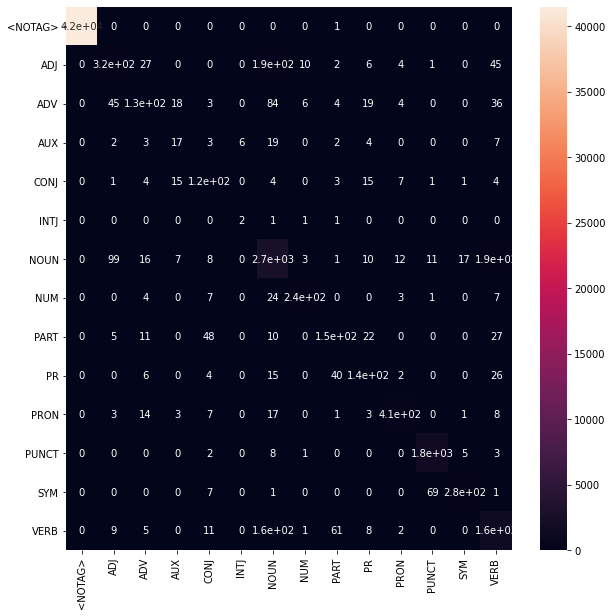

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
categories=UNIQUE_TAGS[:-1]
plt.figure(figsize=(10,10))
sns.heatmap(ss, annot=True, xticklabels=categories, yticklabels=categories)

## Применение полученных теггеров и сравнение

In [ ]:
# single_token_model.load_state_dict(torch.load('/content/stepik-dl-nlp/models/single_token_pos.pth', map_location={'cuda:0': 'cpu'}))
sentence_level_model.load_state_dict(torch.load('./stepik-dl-nlp/models/sentence_level_pos.pth'))

<All keys matched successfully>

In [ ]:
# single_token_pos_tagger = POSTagger(single_token_model, char_vocab, UNIQUE_TAGS, MAX_SENT_LEN, MAX_ORIG_TOKEN_LEN)
sentence_level_pos_tagger = POSTagger(sentence_level_model, char_vocab, UNIQUE_TAGS, MAX_SENT_LEN, MAX_ORIG_TOKEN_LEN)

In [ ]:
test_sentences = [
    'Кини миигин күн аайы көрөөччү.',
    'Маша ааны аста уонна кылааһын диэки сүүрэ турда.',
    'Аныгы оскуола бастакы кылааһын оҕолоро наһаа да кыракыйдар, тугу да бэйэлэрэ сатаабаттар.',
    'Эн миигин кытта ыраах айаҥҥа барсыан этэ дуо?',
    'Билиҥҥи сайдыылаах кэмҥэ культурнай киһи биир омук тылын билиэхтээх диэн мин бигэ санаалаахпын.',
    'Саха сирин хайыһарга сүүмэрдэммит хамаандата билигин Новосибирскай куоракка үөрэнэр дьарыкка сылдьар.',
    'М.К.Аммосов аатынан ХИФУ автодорожнай факультетын бастакы кууруһугар үөрэнэбин.',
    'Онтон төрдүс кылаастан Анатолий Афанасьевич Артемьевка, Олимпийскай Эрэл училищетыгар Петр Петрович Лукачевскайга, Яков Гаврильевич Поповка эрчиллибитим.'
]
test_sentences_tokenized = tokenize_corpus(test_sentences, min_token_size=1)

In [ ]:
for sent_tokens, sent_tags in zip(test_sentences_tokenized, single_token_pos_tagger(test_sentences)):
    print(' '.join('{}-{}'.format(tok, tag) for tok, tag in zip(sent_tokens, sent_tags)))
    print()

In [ ]:
for sent_tokens, sent_tags in zip(test_sentences_tokenized, sentence_level_pos_tagger(test_sentences)):
    print(' '.join('{}-{}'.format(tok, tag) for tok, tag in zip(sent_tokens, sent_tags)))
    print()

1it [00:00, 199.71it/s]                 

кини-PRON миигин-NOUN күн-NOUN аайы-PR көрөөччү-NOUN

маша-NOUN ааны-NOUN аста-NUM уонна-CONJ кылааһын-NOUN диэки-PR сүүрэ-VERB турда-VERB

аныгы-NOUN оскуола-NOUN бастакы-NUM кылааһын-NOUN оҕолоро-NOUN наһаа-VERB да-CONJ кыракыйдар-VERB тугу-ADJ да-CONJ бэйэлэрэ-PRON сатаабаттар-VERB

эн-PRON миигин-NOUN кытта-PR ыраах-ADJ айаҥҥа-NOUN барсыан-VERB этэ-PART дуо-PART

билиҥҥи-ADJ сайдыылаах-ADJ кэмҥэ-NOUN культурнай-ADJ киһи-NOUN биир-NUM омук-NOUN тылын-NOUN билиэхтээх-ADJ диэн-PART мин-PRON бигэ-ADV санаалаахпын-NOUN

саха-NOUN сирин-NOUN хайыһарга-VERB сүүмэрдэммит-VERB хамаандата-NOUN билигин-ADV новосибирскай-ADJ куоракка-NOUN үөрэнэр-VERB дьарыкка-VERB сылдьар-VERB

м-NOUN к-ADJ аммосов-NOUN аатынан-NOUN хифу-NOUN автодорожнай-ADJ факультетын-NOUN бастакы-NUM кууруһугар-NOUN үөрэнэбин-VERB

онтон-CONJ төрдүс-ADJ кылаастан-NOUN анатолий-NOUN афанасьевич-NOUN артемьевка-NOUN олимпийскай-NOUN эрэл-NOUN училищетыгар-NOUN петр-NOUN петрович-NOUN лукачевскайга-NOUN яков-NOUN гаврильевич

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/Диссертация/данные/all_sent.zip'
# !unzip '/content/drive/MyDrive/Диссертация/данные/korpus3_sent.zip'
# !unzip '/content/drive/MyDrive/Диссертация/данные/Alampa_sent.zip'
!unzip '/content/drive/MyDrive/Диссертация/данные/Dalan_sent.zip'
# !unzip '/content/drive/MyDrive/Диссертация/данные/Dalan_tygyn_sent.zip'
# !unzip '/content/drive/MyDrive/Диссертация/данные/Sakhawiki_sent.zip'
# !unzip '/content/drive/MyDrive/Диссертация/данные/collector_sent.zip'

Archive:  /content/drive/MyDrive/Диссертация/данные/Dalan_sent.zip
  inflating: Dalan_sent.txt          


In [ ]:
import os
collection = []
for file in os.listdir("/content/"):
    if file.endswith(".txt"):
        print(file)
        with open(file) as f:
            for line in f:
                sakha = f.readline()
                sakha = sakha.replace("\n", " ").split()
                collection += sakha

collection = ' '.join(collection)

Dalan_sent.txt


In [ ]:
len(collection)

320976

In [ ]:
collection[2100000:4100144]

' сиилии-хоһулуу көрсүбүт олохтоох ойуун өйүн сүтэрэн охтон түспүт. » диэбитигэр кинини үгэргии көрсүбүт мааны дьахтар таҥаһа барыта суох буолан баран сыгынньах хотон айаҕар модьоҕону туора охтон түспүт. Дьахтар аҕата «мэйии мэҥиэтэ, тыын толуга наада буоллаҕына миигин ыл, кыыспын аһын» диэн көрдөспүт. Онтон туох бэрик эрэйиллэрин иччилэртэн ыйыталаһан, дьиэ тойон өһүөтүн туһунан дүҥүрүн тоҥсуйа турбахтаабыт. Онтон ойуун били дьахтар аҕатыгар туһаайан «кыыһыҥ тыынын толугар биир үөргүт атыырын уонна биир талыы биэни ыллым. Аҕаҕыт түүн үөһүгэр хараҕын арыйыаҕа. Сэттэ күнүнэн муус өлүөрүгэр түһүөҕэ. Кини үс сылынан өлүөхтээх этэ. Кини тыынын аҕаҕытыгар салҕаатым. Аҕаҕыт тыынын толугар кини эмиэ өлүөҕэ. Ойууну улаханнык маанылаан, үс ат ындыыта бэлэх биэрэн дойдутугар атаарбыттар. Ол да гыннар дьиэтин кэриэтэ оҥостубут хотонуттан арахсыан баҕарбатаҕа. Ыанньыксыттар арай биир сөбүлээбэппит диирдээхтэр – Микиис тылын төрдө наар эриэтикэ, сиэкис. Ыксаан, биригэдьиир Өлөксөйгө «атын сиргэ көһ

In [ ]:
def split_into_sentences(text):
    text = re.sub("уо[.]д[.]а[.] *" + alphabets_1,"<pip1>. \\1",text)
    text = re.sub("о[.]д[.]а[.] *" + alphabets_1,"<pip2>. \\1",text)
    text = re.sub(" с[.] *" + alphabets_1," с<pip3>. \\1",text)
    text = re.sub(" м[.] *" + alphabets_1," м<pip3>. \\1",text)
    text = re.sub("солк[.] *" + alphabets_1,"солк<pip3>. \\1",text)
    text = re.sub("тыһ[.] *" + alphabets_1,"тыһ<pip3>. \\1",text)
    text = re.sub(" тыс[.] *" + alphabets_1," тыc<pip3>. \\1",text)
    text = re.sub(" мөл[.] *" + alphabets_1," мөл<pip3>. \\1",text)
    text = re.sub(diggi + "[.] *" + alphabets_1,"\\1<pip3>. \\2",text)

    text = re.sub(alphabets_1 + "[.]","\\1<pip3>",text)
    text = re.sub(diggi + "[.]","\\1<pip3>",text)

    text = re.sub("уо[.]д[.]а.","<pip1>",text)
    text = re.sub("о[.]д[.]а.","<pip2>",text)
    text = re.sub("О[.]э[.]","<pip4>",text)
    text = re.sub("О[.]и[.]","<pip7>",text)
    text = re.sub("о[.]э[.]","<pip5>",text)
    text = re.sub("о[.]и[.]","<pip6>",text)

    text = re.sub(" гр[.]"," гр<pip3> ",text)
    text = re.sub(" кв[.]"," кв<pip3> ",text)
    text = re.sub(" г[.]"," г<pip3> ",text)
    text = re.sub(" т[.]"," г<pip3> ",text)
    text = re.sub(" c[.]"," c<pip3>",text)
    text = re.sub(" м[.]"," м<pip3>",text)
    text = re.sub("тыһ[.]","тыһ<pip3>",text)
    text = re.sub(" тыс[.]"," тыс<pip3>",text)
    text = re.sub(" стр[.]"," стр<pip3>",text)
    text = re.sub(" ыст[.]"," ыст<pip3>",text)
    text = re.sub("солк[.]","солк<pip3>",text)
    text = re.sub(" уул[.]"," уул<pip3>",text)
    text = re.sub(" мөл[.]"," мөл<pip3>",text)
    text = re.sub(" ыст[.]"," ыст<pip3>",text)

    text = re.sub("--"," ",text)
    text = re.sub('[.] *[.]', '.',text)
    text = re.sub('[!] *[.]', '!',text)
    text = re.sub('[?] *[.]', '?',text)
    text = re.sub('[:] *[.]', ':',text)
    text = re.sub('[?] *[!]', '?',text)
    text = re.sub('[?] *[»]', "<pip8>»",text)
    text = re.sub('[?] *[”]', "<pip8>”",text)
    text = re.sub('[?] *[)]', "<pip8>)",text)
    text = re.sub('[!] *[»]', "<pip9>»",text)
    text = re.sub('[!] *[”]', "<pip9>”",text)
    text = re.sub('[!] *[)]', "<pip9>)",text)
    

    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")

    text = text.replace("<pip1>","уо.д.а.")
    text = text.replace("<pip2>","о.д.а.")
    text = text.replace("<pip3>",".")
    text = text.replace("<pip4>","О.э.")
    text = text.replace("<pip5>","о.э.")
    text = text.replace("<pip6>","о.и.")
    text = text.replace("<pip7>","О.и.")
    text = text.replace("<pip8>","?")
    text = text.replace("<pip9>","!")

    text = re.sub(r' +', ' ',text)
    text = re.sub(r'<stop> +', '<stop>',text)
    text = re.sub(r'[.] +[.]', '.',text)

    sentences = text.split("<stop>")
    return sentences

In [ ]:
import re
alphabets_1= '([ЙЦУКЕНГШЩЗХФЫВАПРОЛДЖЭЯЧСМИТБЮӨҮ])'
diggi = '([1234567890])'

In [ ]:
sentences = split_into_sentences(collection)

In [ ]:
len(sentences)

5650

In [ ]:
sentences1 = []
for i in range(len(sentences)):
    pp = 0
    k = sentences[i].split()
    kk = 0
    for j in k:
      if len(j) > 25:
        kk = 1
    pp = len(sentences[i])
    if kk ==0 and pp < 76:
      sentences1.append(sentences[i])

In [ ]:
len(sentences1)

4328

In [ ]:
sentences1[0]

'ДАЛАН.ДьИКТИ СААС..'

In [ ]:
with open("razm.txt", "w") as output: 
        test_sentences_tokenized = tokenize_corpus(sentences1, min_token_size=1)
        for sent_tokens, sent_tags in zip(test_sentences_tokenized, sentence_level_pos_tagger(sentences1)):
            output.write(' '.join('{}-{}'.format(tok, tag) for tok, tag in zip(sent_tokens, sent_tags))+'\n')

136it [00:02, 46.96it/s]                            


In [ ]:
data = open("verbs_cnn.txt", "w")
with open('/content/razm.txt') as f:
    line = f.read()
    line = line.replace("\n","")
    a = line.split('-')


In [ ]:
len(a)

2563247

In [ ]:
sen = []
for i in range(len(a)):
  if 'VERB' in a[i]:
    sen.append(a[i-1])



In [ ]:
len(sen)

688310

In [ ]:
sen[0][4:]

'эрдэхпитинэ'

In [ ]:

 'SYM': 12,
 'VERB': 13,
 'X': 14}

In [ ]:
senn = []
for i in sen:
  if 'NOUN' in i:
    senn.append(i[4:])
  elif 'VERB' in i:
    senn.append(i[4:])
  elif 'ADJ' in i:
    senn.append(i[3:])
  elif 'ADV' in i:
    senn.append(i[3:])
  elif 'AUX' in i:
    senn.append(i[3:])
  elif 'CONJ' in i:
    senn.append(i[4:])
  elif 'INTJ' in i:
    senn.append(i[4:])
  elif 'NUM' in i:
    senn.append(i[3:])
  elif 'PART' in i:
    senn.append(i[4:])
  elif 'PR' in i and 'PRON' not in i:
    senn.append(i[2:])
  elif 'PRON' in i:
    senn.append(i[4:])
  elif 'PUNCT' in i:
    senn.append(i[5:])
  elif 'SYM' in i:
    senn.append(i[3:])
  elif 'X' in i:
    senn.append(i[1:])
    

In [ ]:
len(senn)

688288

In [ ]:
semm = set(senn)

In [ ]:
len(semm)

68702

In [ ]:
data = open("verbs_cnn.txt", "w")
for i in semm:
  data.write(i+'\n')


In [ ]:
with open("verbs_cnn.txt", "w") as output:
    for sentence in full:
        for token in sentence:
            if token.upos =='VERB':
                output.write(token.form+'\n')